# 单无人机路径规划————最短路径的引导

（注意：运行本程序需要获得task3中生成的env_discretizing.pkl文件）

让我们将<a href="task3_SUAV_RL_Design.ipynb">无人机强化学习任务</a>中单无人机路径规划部分生成的环境文件加载进来

In [1]:
import sys
sys.path.append('..')
import UAVENVmudule_design as UE

import pickle
with open("env_discretizing.pkl", "rb") as file:
    env_discretizing = pickle.load(file)

对于此环境，本节我们用最短路径对无人机进行引导飞行。

我们设计一个**神经网络-蚁群算法**的组合方法，以实现最短路径的引导飞行。在该方法中，我们用神经网络代替蚁群算法中的蚂蚁，用神经网络的输出作为蚂蚁的移动方向，使用强化学习的策略来更新网络参数。

##### 蚂蚁选择路径原理

对于单个蚂蚁，我们将其视为智能体，用神经网络来模拟其行为。神经网络的输入为当前状态，输出为前进的位置。神经网络的训练目标是使其输出与最终路径规划目标越接近越好。  
蚂蚁输入可用三元组$<E,\ D,\ B>$，其中$E$为当前蚂蚁待前进位置周围环境，$D$为待前进位置距离终点的距离，$B$为待前进位置蚂蚁前进过的次数，我们将对这三种信息分别进行相关预处理，使信息特征对齐，再将其输入神经网络，得到最后的待前进位置。

**$E$信息处理**  
$E$表示某位置，或某位置序列的周围环境信息，我们将对周围环境的障碍物信息进行分析，将其映射到0~1，0表示该位置周围环境不好，没有出路；1表示该位置周围环境好，有其他待选的出路。

**$D$信息处理**  
$D$表示待前进位置距离终点的距离，我们将其映射到0~1，0表示该位置距离终点相对较远；1表示该位置距离终点相对较近。

**$B$信息处理**  
$B$表示待前进位置蚂蚁前进过的次数，我们将其映射到0~1，0表示该位置基本没有蚂蚁来过，1表示该位置有很多蚂蚁来过。

我们将三组信息输入一神经网络，得到待前进位置。

##### 训练策略
从某点出发，进行路径选择，直到到达终点。在每一步，我们用神经网络选择待前进位置。最后，利用较好的路径更新网络参数。

让我们先看看当前环境吧！

f:\desk\Design-of-Simple-Python-UAV-Env\tasks_design\..\UAVENVmudule_design\env_design\env.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, cmap=cm.coolwarm, edgecolor='k')


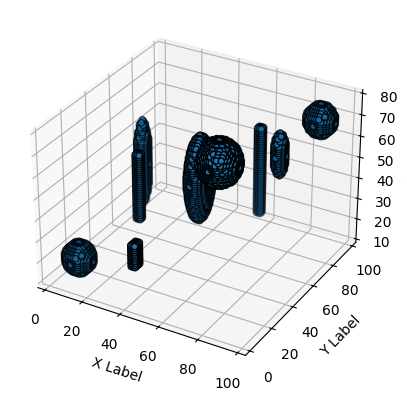

In [3]:
env_discretizing.show_discretized_env()

##### 设计网络，初始化必要参数

In [8]:
import torch

class AntNet(torch.nn.Module):
    '''
    “蚂蚁”网络结构
    '''
    def __init__(self, input_size, output_size):
        super(AntNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.softmax(x, dim=1)
        return x